<a href="https://colab.research.google.com/github/EnricoMariaFerrari/Dueling-Deep-Reinforcement-Learning/blob/main/RL_project_ATARI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# INSTALLATIONS

# 1. Installare PyTorch
!pip install torch torchvision

# 2. Installare una versione specifica di Gymnasium
!pip install gymnasium==0.29.1

# 3. Installare pacchetti relativi agli ambienti Atari
!pip install 'gymnasium[atari]'
!pip install gymnasium[accept-rom-license]

# 4. Installare altre dipendenze
!pip install opencv-python
!pip install imageio[ffmpeg]
!pip install matplotlib

In [ ]:
# MODEL

# Implementation of the class for the one-stream Deep Q-Network (DQN) and Dueling Deep Q-Network (DuelDQN) models used inside DQL algorithm.
# These models have 4 images as input (=s)

import torch.nn as nn
import torch.nn.functional as F
import torch


# DQN model

class DQN(nn.Module):  # create a subclass of nn.Module for defining the class of our DQN models
    def __init__(self, in_channels, n_actions):  # to instantiate a DQL model, we need the number of channels (in_channels)
    # that is = to the number of images we pass as input, while (n_actions) is the number of actions of the game
        super().__init__()
        # create 3 Conv layers
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)  # 32 8x8 filters with stride 4
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)  # 64 4x4 filters with stride 2
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)  # 64 3x3 filters with stride 1
        # create linear 2 layers
        self.fc1 = nn.Linear(64*7*7, 512)  # 512 neurons
        self.fc2 = nn.Linear(512, n_actions)  # n_actions neurons

    def forward(self, x):  # define the forward function to evaluate an input x in the currently learned model
        '''
        Input shape: (bs,4,84,84) => input s = a tensor bsx4x84x84, i.e. 4 images 84x84, where bs is the number of states we consider
        Output shape: (bs,n_actions) => output = a tensor of bsxn_actions values, that approximate the Q(s,a) for any a
        '''
        # evaluation of the network
        x = F.relu(self.conv1(x))  # for each hidden neuron use ReLu activation function
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # we do not use ReLu in output neurons, since we need to have real approximations of the Q(s,a),
        # and so not constrained to be positive (it is a multivariate regression task)


# Dueling DQN model

class DuelDQN(nn.Module):
    def __init__(self, in_channels, n_actions):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.fc1_val = nn.Linear(64*7*7,128)
        self.fc1_adv = nn.Linear(64*7*7,128)
        self.fc2_val = nn.Linear(128,1)
        self.fc2_adv = nn.Linear(128,n_actions)

    def forward(self, x):
        '''
        Input shape: (bs,c,h,w) #(bs,4,84,84)
        Output shape: (bs,n_actions)
        '''
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x,1)

        #adv = F.relu(self.fc1_adv(x))
        adv = F.leaky_relu(self.fc1_adv(x))
        #adv = F.relu(self.fc2_adv(adv))
        adv = self.fc2_adv(adv)

        val = F.leaky_relu(self.fc1_val(x))
        val = self.fc2_val(val)

        return val + (adv - adv.mean())

# Dueling DQN
class DuelDQNpp(nn.Module):
    def __init__(self, in_channels, n_actions):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.Alinear1 = nn.Linear(64*7*7,128)
        self.Alinear2 = nn.Linear(128,n_actions)
        self.Vlinear1 = nn.Linear(64*7*7,128)
        self.Vlinear2 = nn.Linear(128,1)

    def forward(self, x):
        '''
        Input shape: (bs,c,h,w) #(bs,4,84,84)
        Output shape: (bs,n_actions)
        '''
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x,1)

        Ax = F.leaky_relu(self.Alinear1(x))
        Ax = self.Alinear2(Ax)

        Vx = F.leaky_relu(self.Vlinear1(x))
        Vx = self.Vlinear2(Vx)

        return Vx + (Ax - Ax.mean())

In [ ]:
# UTILS


import cv2
import numpy as np
from collections import namedtuple, deque
import random
import imageio
import os

def process_image(image, crop_size=(34,194,0,160),target_size=(84,84),normalize=True):
    '''
    Grayscale, crop and resize image

    Input
    - image: shape(h,w,c),(210,160,3)
    - crop_size: shape(min_h,max_h,min_w,max_w)
    - target_size: (h,w)
    - normalize: [0,255] -> [0,1]

    Output
    - shape(84,84)
    '''
    frame = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # To grayscale
    frame = frame[crop_size[0]:crop_size[1],crop_size[2]:crop_size[3]]
    frame = cv2.resize(frame, target_size, interpolation=cv2.INTER_AREA)  # Resize
    if normalize:
        return frame.astype(np.float32)/255 #normalize
    else:
        return frame


# structure to incorporate batches of transitions
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

# to define ReplayMemory objects
class ReplayMemory:
    def __init__(self, capacity, batch_size):  # insert capacity of the buffer and the size of the batch to sample from it
        self.memory = deque([], maxlen=capacity)  # ReplayMemory.memory = deque of such capacity = buffer
        self.batch_size = batch_size

    def push(self, *args):  # method to append a transition = tuple of experience, at the beginning of the buffer
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):  # method tu sample uniformly batch_size tuples in the buffer
        '''
        return List[Transition]
        '''
        return random.sample(self.memory, self.batch_size)

    def __len__(self):  # to return the length of the buffer
        return len(self.memory)


class VideoRecorder:
    def __init__(self, dir_name, fps=30):
        self.dir_name = dir_name
        self.fps = fps
        self.frames = []

    def reset(self):
        self.frames = []

    def record(self, frame):
        self.frames.append(frame)

    def save(self, file_name):
        path = os.path.join(self.dir_name, file_name)
        imageio.mimsave(path, self.frames, fps=self.fps, macro_block_size = None)



# function to select an action using epsilon-greedy for the current learned policy, with updated epsilon
# input: state s
# output: action a to take

def select_action(state:torch.Tensor)->torch.Tensor:
    '''
    epsilon greedy
    - epsilon: choose random action
    - 1-epsilon: argmax Q(a,s)

    Input: state shape (1,4,84,84)

    Output: action shape (1,1)
    '''
    global eps_threshold  # use current global epsilon value and number of steps done
    global steps_done
    sample = random.random()  # sample uniformly a value in [0,1]
    eps_threshold = EPS_END + (EPS_START - EPS_END)*math.exp(-1. * steps_done / EPS_DECAY)  # update value of epsilon

    steps_done += 1  # update number of steps done
    if sample > eps_threshold:  # with probability epsilon take action given s following greedy(Q), for the currently learned Q
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)  # a = argmax_a' Q(s,a')
    else:
        return torch.tensor([[env.action_space.sample()]]).to(device)  # take an action for the current environment between the possible ones uniformly


In [ ]:
# Define class SegmentTree to create a Segment tree object

class SegmentTree:
    def __init__(self, capacity):  # O(n) operations, where n = capacity
        """
        Inizializza un Segment Tree con la capacità specificata.
        :param capacity: Numero massimo di elementi
        """
        self.capacity = capacity
        #self.tree = [0] * (2 * capacity)  # Array per il Segment Tree
        self.tree = [torch.tensor([0.0], device= 'cpu') for _ in range(2 * capacity)]

    def update(self, idx, value):  # O(log(n)) operations
        """
        Aggiorna il valore dell'elemento e i nodi del Segment Tree.
        :param idx: Indice dell'elemento (0-based)
        :param value: Nuovo valore
        """
        idx += self.capacity  # Passa all'indice della foglia
        #self.tree[idx] = value
        self.tree[idx] = torch.tensor([value], device=self.tree[idx].device)

        # Aggiorna i nodi superiori
        while idx > 1:
            idx //= 2
            self.tree[idx] = self.tree[2 * idx] + self.tree[2 * idx + 1]

    def sum(self, left, right):  # O(log(n)) operations
        """
        Calcola la somma sul range [left, right).
        :param left: Inizio del range
        :param right: Fine del range (esclusivo)
        :return: Somma sul range
        """
        #result = 0
        result = torch.tensor([0.0], device=self.tree[0].device) # initialize with a tensor
        left += self.capacity
        right += self.capacity

        while left < right:
            if left % 2 == 1:  # Se è un nodo destro
                result += self.tree[left]
                left += 1
            if right % 2 == 1:  # Se è un nodo sinistro
                right -= 1
                result += self.tree[right]
            left //= 2
            right //= 2

        #return result
        return result[0]

    def find_prefix_sum_index(self, target):  # O(log(n)) operations
        """
        :param target: valore x
        :return: il primo indice i tale che sum(a[0,...,i])>=x
        """
        idx = 1  # Nodo radice
        while idx < self.capacity:  # Scendi fino a una foglia
            if self.tree[2 * idx] >= target:
                idx = 2 * idx  # Vai a sinistra
            else:
                target -= self.tree[2 * idx]
                idx = 2 * idx + 1  # Vai a destra
        return idx - self.capacity

# Create class for a Priorized Replay Buffer object

class PrioritizedReplayMemory:
    def __init__(self, capacity, batch_size, alpha=0.6, beta=0.4):
        """
        Inizializza il Replay Buffer Prioritizzato con un Segment Tree.
        :param capacity: Numero massimo di transizioni
        :param alpha: Esponente per il calcolo delle priorità
        """
        self.capacity = capacity
        self.alpha = alpha
        self.beta = beta
        self.batch_size = batch_size
        self.buffer = [None] * capacity  # Buffer circolare
        self.priorities = SegmentTree(capacity)  # Segment Tree for priorities to the power alpha
        self.min_priority = 1e-5  # Priorità minima
        self.index = 0  # Indice per il buffer
        self.max_priority_alpha = 1

    def push(self, *args):
        """
        Aggiunge una nuova transizione nel buffer.
        :param args: Transizione (stato, azione, ricompensa, next_state, done)
        """
        transition = Transition(*args)

        # Inserisci la transizione nel buffer circolare
        self.buffer[self.index] = transition
        self.priorities.update(self.index, self.max_priority_alpha)

        # Aggiorna l'indice circolare
        self.index = (self.index + 1) % self.capacity

    def sample(self):
        """
        Campiona un batch di transizioni in base alla priorità.
        :param beta: Esponente per correggere il bias del campionamento
        :return: (batch, indices, IS_weights)
        """
        batch = []
        indices = []
        priorities = []

        segment = self.priorities.sum(0, self.capacity)

        for i in range(self.batch_size):
           #target = np.random.uniform(0, segment)
           target = np.random.uniform(0, segment.cpu().numpy())
           idx = self.priorities.find_prefix_sum_index(target)

           batch.append(self.buffer[idx])
           indices.append(idx)
           priorities.append(self.priorities.tree[idx + self.capacity])

        # Calcola i pesi di importanza del campionamento
        #probabilities = np.array(priorities) / self.priorities.sum(0, self.capacity).cpu().numpy()  ###
        probabilities = np.array([p.cpu().numpy() for p in priorities]) / self.priorities.sum(0, self.capacity).cpu().numpy()  ###
        is_weights = (self.capacity * probabilities) ** (-self.beta) #(len(self.buffer) * probabilities) ** (-beta) # since we use buffer to do importance sampling only when it is full!
        is_weights /= is_weights.max()  # Normalizza i pesi

        return batch, indices, is_weights

    def update_priorities(self, indices, errors):
        """
        Aggiorna le priorità in base agli errori TD.
        :param indices: Indici delle transizioni
        :param errors: Errori di TD
        """
        for idx, error in zip(indices, errors):
            priority_alpha = (abs(error) + self.min_priority) ** self.alpha
            self.max_priority_alpha = max(self.max_priority_alpha, priority_alpha)
            self.priorities.update(idx, priority_alpha)

    def __len__(self):
        return len([x for x in self.buffer if x is not None])

In [ ]:
# Checks

aa = SegmentTree(8)
aa.update(0,10)
aa.update(1,3)
aa.update(2,1)
aa.update(3,40)
aa.update(4,1)
aa.update(5,15)
aa.update(6,1)
aa.update(7,0)
print(aa.sum(0,8))
#aa.update(0,100)
#aa.sum(6,10)
#aa.find_prefix_sum_index(100)
print((aa.tree[3:]))
print(max((aa.tree[3:]), default=1.0))

aa = PrioritizedReplayMemory(6,2)
aa.push(1,2,3,4,5)
aa.push(1,2,3,4,5)
aa.push(1,2,3,4,5)
aa.push(1,2,3,4,5)
aa.push(1,2,3,4,5)
aa.push(1,2,3,4,5)
aa.push(1,2,3,4,5)
aa.push(1,2,3,4,5)
aa.sample()

In [ ]:
# WRAPPER


from typing import Dict, SupportsFloat,Tuple,Any
import gymnasium as gym
import numpy as np
from gymnasium import spaces
import cv2


# define the type of output of some methods we'll define

AtariResetReturn = Tuple[np.ndarray, Dict[str, Any]]  # it will be the next state (as np.ndarray) and a dictionary with str keys and any type for the value
# so, when we reset the environment, we'll return the new initial state and a dict of info
AtariStepReturn = Tuple[np.ndarray, SupportsFloat, bool, bool, Dict[str, Any]]
# current state s', reward r, boolean (True if episode is finished), boolean (True if episode finished since max number of steps reached), info


# Sticky actions
# define the class StickyActionEnv that is a gym.Wrapper, that takes an np.ndarray as state, int as action, returns np.ndarray as next state, int as reward

class StickyActionEnv(gym.Wrapper[np.ndarray, int, np.ndarray, int]):

    def __init__(self, env: gym.Env, action_repeat_probability: float) -> None:
        super().__init__(env)  # the environment
        self.action_repeat_probability = action_repeat_probability  # the probability that an action we pass is repeated also in the next step
        # this is done to introduce noise in the correspondence between envirovnment and agent, to be able to learn also in this case
        assert env.unwrapped.get_action_meanings()[0] == "NOOP"  # check if the action NOOP is available and corresponds to int 0 for the environment

    # method to reset the environment
    def reset(self, **kwargs) -> AtariResetReturn:
        self._sticky_action = 0  # NOOP  # we setup the action to be NOOP, i.e. no action
        return self.env.reset(**kwargs)  # reset the environment and return the initial state

    # method to do one step with sticky action
    def step(self, action: int) -> AtariStepReturn:  # take one action
        if self.np_random.random() >= self.action_repeat_probability:  # with prob action_repeat_probability repeat the previous action, otherwise update it with action
            self._sticky_action = action
        return self.env.step(self._sticky_action)


# define the class NoopResetEnv that is a gym.Wrapper, ###########################

class NoopResetEnv(gym.Wrapper[np.ndarray, int, np.ndarray, int]):
    """
    Sample initial states by taking random number of no-ops on reset.
    No-op is assumed to be action 0.

    :param env: Environment to wrap
    :param noop_max: Maximum value of no-ops to run
    """

    def __init__(self, env: gym.Env, noop_max: int = 30) -> None:
        super().__init__(env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0

        assert env.unwrapped.get_action_meanings()[0] == "NOOP"  # type: ignore[attr-defined]

    def reset(self, **kwargs) -> AtariResetReturn:
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.integers(1, self.noop_max + 1)
        assert noops > 0
        obs = np.zeros(0)
        info: Dict = {}
        for _ in range(noops):
            obs, _, terminated, truncated, info = self.env.step(self.noop_action)
            if terminated or truncated:
                obs, info = self.env.reset(**kwargs)
        return obs, info



class FireResetEnv(gym.Wrapper[np.ndarray, int, np.ndarray, int]):
    """
    Take action on reset for environments that are fixed until firing.

    :param env: Environment to wrap
    """

    def __init__(self, env: gym.Env) -> None:
        super().__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == "FIRE"  # type: ignore[attr-defined]
        assert len(env.unwrapped.get_action_meanings()) >= 3  # type: ignore[attr-defined]

    def reset(self, **kwargs) -> AtariResetReturn:
        self.env.reset(**kwargs)
        obs, _, terminated, truncated,info = self.env.step(1)
        if terminated or truncated:
            self.env.reset(**kwargs)
        obs, _, terminated, truncated, info = self.env.step(2)
        if terminated or truncated:
            self.env.reset(**kwargs)
        return obs, info


class EpisodicLifeEnv(gym.Wrapper[np.ndarray, int, np.ndarray, int]):
    """
    Make end-of-life == end-of-episode, but only reset on true game over.
    Done by DeepMind for the DQN and co. since it helps value estimation.

    :param env: Environment to wrap
    """

    def __init__(self, env: gym.Env) -> None:
        super().__init__(env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action: int) -> AtariStepReturn:
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.was_real_done = terminated or truncated

        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()  # type: ignore[attr-defined]
        if 0 < lives < self.lives:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so its important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            terminated = True

        self.lives = lives
        return obs, reward, terminated, truncated, info

    def reset(self, **kwargs) -> AtariResetReturn:
        """
        Calls the Gym environment reset, only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.

        :param kwargs: Extra keywords passed to env.reset() call
        :return: the first observation of the environment
        """
        if self.was_real_done:
            obs, info = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, terminated, truncated, info = self.env.step(0)

            # The no-op step can lead to a game over, so we need to check it again
            # to see if we should reset the environment and avoid the
            # monitor.py `RuntimeError: Tried to step environment that needs reset`
            if terminated or truncated:
                obs, info = self.env.reset(**kwargs)

        self.lives = self.env.unwrapped.ale.lives()  # type: ignore[attr-defined]
        return obs, info


class MaxAndSkipEnv(gym.Wrapper[np.ndarray, int, np.ndarray, int]):
    """
    Return only every ``skip``-th frame (frameskipping)
    and return the max between the two last frames.

    :param env: Environment to wrap
    :param skip: Number of ``skip``-th frame
        The same action will be taken ``skip`` times.
    """

    def __init__(self, env: gym.Env, skip: int = 4) -> None:
        super().__init__(env)
        # most recent raw observations (for max pooling across time steps)
        assert env.observation_space.dtype is not None, "No dtype specified for the observation space"
        assert env.observation_space.shape is not None, "No shape defined for the observation space"
        self._obs_buffer = np.zeros((2, *env.observation_space.shape), dtype=env.observation_space.dtype)
        self._skip = skip

    def step(self, action: int) -> AtariStepReturn:
        """
        Step the environment with the given action
        Repeat action, sum reward, and max over last observations.

        :param action: the action
        :return: observation, reward, terminated, truncated, information
        """
        total_reward = 0.0
        terminated = truncated = False
        for i in range(self._skip):
            obs, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += float(reward)
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, terminated, truncated, info


class ClipRewardEnv(gym.RewardWrapper):
    """
    Clip the reward to {+1, 0, -1} by its sign.

    :param env: Environment to wrap
    """

    def __init__(self, env: gym.Env) -> None:
        super().__init__(env)

    def reward(self, reward: SupportsFloat) -> float:
        """
        Bin reward to {+1, 0, -1} by its sign.

        :param reward:
        :return:
        """
        return np.sign(float(reward))


class WarpFrame(gym.ObservationWrapper[np.ndarray, int, np.ndarray]):
    """
    Convert to grayscale and warp frames to 84x84 (default)
    as done in the Nature paper and later work.

    :param env: Environment to wrap
    :param width: New frame width
    :param height: New frame height
    """

    def __init__(self, env: gym.Env, width: int = 84, height: int = 84, normalize: bool = True, video = None) -> None:
        super().__init__(env)
        self.width = width
        self.height = height
        self.normalize = normalize
        self.video = video
        assert isinstance(env.observation_space, spaces.Box), f"Expected Box space, got {env.observation_space}"

        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(self.height, self.width, 1),
            dtype=env.observation_space.dtype,  # type: ignore[arg-type]
        )

    def observation(self, frame: np.ndarray) -> np.ndarray:
        """
        returns the current observation from a frame

        :param frame: environment frame
        :return: the observation shape(84,84) by default
        """
        if self.video is not None:
            self.video.record(frame)
        return process_image(frame,target_size=(self.width, self.height),normalize=self.normalize)


class AtariWrapper(gym.Wrapper[np.ndarray, int, np.ndarray, int]):
    """
    Atari 2600 preprocessings

    Specifically:

    * Noop reset: obtain initial state by taking random number of no-ops on reset.
    * Frame skipping: 4 by default
    * Max-pooling: most recent two observations
    * Termination signal when a life is lost.
    * Resize to a square image: 84x84 by default
    * Grayscale observation
    * Clip reward to {-1, 0, 1}
    * Sticky actions: disabled by default
    * Normalize the rgb output to [0,1]

    See https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/
    for a visual explanation.

    .. warning::
        Use this wrapper only with Atari v4 without frame skip: ``env_id = "*NoFrameskip-v4"``.

    :param env: Environment to wrap
    :param noop_max: Max number of no-ops
    :param frame_skip: Frequency at which the agent experiences the game.
        This correspond to repeating the action ``frame_skip`` times.
    :param screen_size: Resize Atari frame
    :param terminal_on_life_loss: If True, then step() returns done=True whenever a life is lost.
    :param clip_reward: If True (default), the reward is clip to {-1, 0, 1} depending on its sign.
    :param action_repeat_probability: Probability of repeating the last action
    """

    def __init__(
        self,
        env: gym.Env,
        noop_max: int = 30,
        frame_skip: int = 4,
        screen_size: int = 84,
        terminal_on_life_loss: bool = True,
        clip_reward: bool = True,
        action_repeat_probability: float = 0.0,
        normalize: bool = True,
        video = None
    ) -> None:
        if action_repeat_probability > 0.0:
            env = StickyActionEnv(env, action_repeat_probability)
        if noop_max > 0:
            env = NoopResetEnv(env, noop_max=noop_max)
        # frame_skip=1 is the same as no frame-skip (action repeat)
        if frame_skip > 1:
            env = MaxAndSkipEnv(env, skip=frame_skip)
        if terminal_on_life_loss:
            env = EpisodicLifeEnv(env)
        if "FIRE" in env.unwrapped.get_action_meanings():  # type: ignore[attr-defined]
            env = FireResetEnv(env)
        env = WarpFrame(env, width=screen_size, height=screen_size, normalize=normalize,video=video)
        if clip_reward:
            env = ClipRewardEnv(env)

        super().__init__(env)

if __name__ == "__main__":
    env = gym.make("BreakoutNoFrameskip-v4")
    #print(env.unwrapped.ale.lives())
    env = AtariWrapper(env)
    obs, info = env.reset()
    env.close()
    for i in range(10000):
        observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
        if terminated or truncated:
            print(env.unwrapped.ale.lives())
            break
    # video.save("aaa.mp4")

4


In [ ]:
class ExtendedActionSpaceWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.noop_variants = [env.action_space.n + i for i in range(15)]  # 30 nuove NOOP
        self.true_noop_action = 0  # La vera azione NOOP è sempre 0

        # Modifica lo spazio delle azioni per includere le nuove NOOP
        self.action_space = spaces.Discrete(env.action_space.n + len(self.noop_variants))

    def step(self, action):
        # Se l'azione scelta è una NOOP fittizia, esegui NOOP vera
        if action in self.noop_variants:
            action = self.true_noop_action
        return self.env.step(action)

In [ ]:
def select_action(state):
    global steps_done
    global eps_threshold

    # Aggiornamento del valore di epsilon con il decadimento
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    if random.random() < eps_threshold:  # esplorazione
        return torch.tensor([[random.randint(0, env.action_space.n - 1)]], device=device, dtype=torch.long)
    else:  # sfruttamento
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)

In [ ]:
env = gym.make("BreakoutNoFrameskip-v4")
env = ExtendedActionSpaceWrapper(env)
env = AtariWrapper(env)
n_action = env.action_space.n
print(n_action)

19


In [ ]:
# TRAINING


import gymnasium as gym
import argparse
from torch import optim
import numpy as np
import random
import torch
import torch.nn as nn
from itertools import count
import os
import matplotlib.pyplot as plt
import math
from collections import deque


def experiment(**kwargs):

  # definition of the experiment
  env_name = kwargs.get('env_name')
  model = kwargs.get('model')
  double = kwargs.get('double')
  lr = kwargs.get('lr')
  n_episodes = kwargs.get('n_episodes')
  batch_size = kwargs.get('batch_size')
  buffer_size = kwargs.get('buffer_size')
  eval_cycle = kwargs.get('eval_cycle')
  GAMMA = kwargs.get('GAMMA')
  EPS_START = kwargs.get('EPS_START')
  EPS_END = kwargs.get('EPS_END')
  EPS_DECAY = kwargs.get('EPS_DECAY')
  WARMUP = kwargs.get('WARMUP')
  time_penalty = kwargs.get('time_penalty')  # penalty for the last of the game
  priority = kwargs.get('priority')
  device = kwargs.get('device')

  # hyperparameters

  global steps_done
  global eps_threshold
  steps_done = 0 # initialize the num of steps done = num of policy improvements = num of SGD steps
  eps_threshold = EPS_START  # initialize the value of epsilon for the epsilon-greedy improvement steps

  # create the environment using library gymnasium
  if env_name == "pong":
      env = gym.make("PongNoFrameskip-v4")
  elif env_name == "breakout":
      env = gym.make("BreakoutNoFrameskip-v4")
  else:
      env = gym.make("BoxingNoFrameskip-v4")

  # define an object AtariWrapper with this environment
  env = ExtendedActionSpaceWrapper(env)############
  env = AtariWrapper(env)
  # the number of possible actions are
  n_action = env.action_space.n # pong:6; breakout:4; boxing:18

  # make directory to store result
  if double == "yes":
      methodname = f"double_{model}"
  else:
      methodname = model
  log_dir = os.path.join(f"log_{env_name}",methodname)
  if not os.path.exists(log_dir):
      os.makedirs(log_dir)
  log_path = os.path.join(log_dir,"log.txt")

  # video
  video = VideoRecorder(log_dir)

  # create network and target network
  global policy_net
  if model == "dqn":
      policy_net = DQN(in_channels=4, n_actions=n_action).to(device)  # policy_net is the network that is directly trained
      target_net = DQN(in_channels=4, n_actions=n_action).to(device)  # target_net is the network that uses the training of
      # policy_net, with a delay, to use a fixed Q-target during the training
  else:
      policy_net = DuelDQN(in_channels=4, n_actions=n_action).to(device)
      target_net = DuelDQN(in_channels=4, n_actions=n_action).to(device)

  # to start, update parameters of target_network with the ones of policy_network. We will synchronize them during the training with in periodic intervals
  target_net.load_state_dict(policy_net.state_dict())
  # impose target_net in only evaluation modality, so that we can only evaluate the target model in batches of examples
  target_net.eval()

  # replay memory

  # create a replay buffer of size buffer_size
  if priority == "No":
      memory = ReplayMemory(buffer_size, batch_size)
  else:
      memory = PrioritizedReplayMemory(buffer_size, batch_size, alpha = priority[0], beta = priority[1])

  # optimizer

  # we use as optimization algorithm Adam with learning rate lr for the training of policy_net
  optimizer = optim.AdamW(policy_net.parameters(), lr=lr, amsgrad=True)

  # warming up

  # before to start the training, we need to do warm-up steps, to sample tuples of experience from the environment with a totally uniform policy for the agent.
  # in this way we can have some experience to fill the buffer.
  print("Warming up...")
  warmupstep = 0
  for episode in count():  # do one episode until ...
      obs, info = env.reset() # (84,84)  # reset the environment and take initial state obs
      obs = torch.from_numpy(obs).to(device) #(84,84)
      # stack four frames together, hoping to learn temporal info
      obs = torch.stack((obs,obs,obs,obs)).unsqueeze(0) #(1,4,84,84)  # state as 4 images!

      # step loop
      for step in count():  # do one (uniform) interaction with the environment until ...
          warmupstep += 1
          # take one step
          action = torch.tensor([[env.action_space.sample()]]).to(device)  # take randomly an action between the availables
          next_obs, reward, terminated, truncated, info = env.step(action.item())
          reward += time_penalty
          done = terminated or truncated

          # convert to tensor
          reward = torch.tensor([reward],device=device) # (1)
          done = torch.tensor([done],device=device) # (1)
          next_obs = torch.from_numpy(next_obs).to(device) # (84,84)
          next_obs = torch.stack((next_obs,obs[0][0],obs[0][1],obs[0][2])).unsqueeze(0) # (1,4,84,84)

          # store the transition in memory
          memory.push(obs,action,next_obs,reward,done)  # to use them to fill the buffer then

          # move to next state
          obs = next_obs

          if done:  # if episode ends break
            break

      if warmupstep > WARMUP:  # if the number of warm-up episodes == WARMUP, break
          break

  # TRAINING

  returnList = []  # list of all sampled returns of the episodes
  lossList = []  # list of all total losses of the episodes
  returndeq = deque([], maxlen=100)  # deque of the last 100 returns
  lossdeq = deque([],maxlen=100)  # deque of the last 100 total losses
  avgreturnlist = []  # list of the average rewards, each avgr computed on an episode
  avglosslist = []  # list of the average losses, each avgl computed on an episode

  # run number the pre-defined num. of episodes
  for episode in range(n_episodes):
      obs, info = env.reset() # (84,84) # obs is the first image_0 seen
      obs = torch.from_numpy(obs).to(device) #(84,84)
      # stack four frames together, hoping to learn temporal info
      obs = torch.stack((obs,obs,obs,obs)).unsqueeze(0) #(1,4,84,84) # take s_0 to be (image_0)^4

      total_loss = 0.0
      total_reward = 0  # to compute the sum of rewards in the episode = return

      # step loop # a step = one interaction with env
      for step in count():
          # take one step
          action = select_action(obs)  # select action a, based on obs = s, according to epsilon-greedy of current learned Q and current epsilon
          next_obs, reward, terminated, truncated, info = env.step(action.item())  # interact with action a with env, returning next image_new, reward r
          reward += time_penalty
          total_reward += reward
          done = terminated or truncated

          # convert to tensor
          reward = torch.tensor([reward],device=device) # (1)
          done = torch.tensor([done],device=device) # (1)
          next_obs = torch.from_numpy(next_obs).to(device) # (84,84)
          next_obs = torch.stack((next_obs,obs[0][0],obs[0][1],obs[0][2])).unsqueeze(0) # (1,4,84,84) # take as s'=(image_new, s[0], s[1], s[2])

          # store the transition in memory
          memory.push(obs,action,next_obs,reward,done)  # push the sampled transition into the buffer

          # move to next state
          obs = next_obs

          # train
          policy_net.train()

          if priority == "No":
            transitions = memory.sample(batch_size)  # sample batch_size tranistions from the buffer   ##################
          else:
            transitions, indices, is_weights = memory.sample()

          batch = Transition(*zip(*transitions)) # batch-array of Transitions -> Transition of batch-arrays.
          state_batch = torch.cat(batch.state) # (bs,4,84,84) # take only the s in the sampled batch
          next_state_batch = torch.cat(batch.next_state) # (bs,4,84,84) # take only the s' in the sampled batch
          action_batch = torch.cat(batch.action) # (bs,1) # take only the a in the sampled batch
          reward_batch = torch.cat(batch.reward).unsqueeze(1) # (bs,1) # take only the r in the sampled batch
          done_batch = torch.cat(batch.done).unsqueeze(1) #(bs,1) # take only the ending-info in the sampled batch

          # Q(st,a)
          state_qvalues = policy_net(state_batch) # (bs,n_actions) # for each s in the buffer evaluate the learned Q(s,a) for any a
          selected_state_qvalue = state_qvalues.gather(1,action_batch) # (bs,1)  # select the computed Q(s,a) for (s,a) sampled

          with torch.no_grad():
              # Q'(st+1,a) for any a # where Q' is target Q-function
              next_state_target_qvalues = target_net(next_state_batch) # (bs,n_actions)
              if double == "yes":
                  # Q(st+1,a)
                  next_state_qvalues = policy_net(next_state_batch) # (bs,n_actions)
                  # argmax Q(st+1,a)
                  next_state_selected_action = next_state_qvalues.max(1,keepdim=True)[1] # (bs,1)
                  # Q'(st+1,argmax_a Q(st+1,a))
                  next_state_selected_qvalue = next_state_target_qvalues.gather(1,next_state_selected_action) # (bs,1)
              else:
                  # max_a Q'(st+1,a)
                  next_state_selected_qvalue = next_state_target_qvalues.max(1,keepdim=True)[0] # (bs,1)

          # td target
          tdtarget = next_state_selected_qvalue * GAMMA * ~done_batch + reward_batch # (bs,1) # so, if we achieved the end_status is reached, we do not have next s',
          # so we update only with reward
          if priority != "No":
            tderror = (selected_state_qvalue - tdtarget)
            memory.update_priorities(indices, tderror)

          # optimize
          if priority == "No":
            criterion = nn.SmoothL1Loss()  # we use L
            loss = criterion(selected_state_qvalue, tdtarget)
            total_loss += loss.item()  # record loss := target - computed Q(s,a)
          else:
            criterion = nn.SmoothL1Loss(reduction='none')
            loss_per_element = criterion(selected_state_qvalue, tdtarget)
            weighted_loss = loss_per_element * torch.from_numpy(is_weights).to(device)
            #loss = weighted_loss.sum()
            loss = weighted_loss.mean()   # why ?  ...
            total_loss += loss.item()
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # let target_net = policy_net every 1000 steps
          if steps_done % 1000 == 0:
              target_net.load_state_dict(policy_net.state_dict())

          if done:  # if the episode is terminated by end or by truncation:
              # eval
              if episode % eval_cycle == 10000: #0  # everu eval_cycle episode we do a video for look at the learning policy
                  with torch.no_grad():
                      video.reset()
                      if env_name == "pong":
                          evalenv = gym.make("PongNoFrameskip-v4")
                      elif env_name == "breakout":
                          evalenv = gym.make("BreakoutNoFrameskip-v4")
                      else:
                          evalenv = gym.make("BoxingNoFrameskip-v4")
                      evalenv = AtariWrapper(evalenv,video=video)
                      obs, info = evalenv.reset()
                      obs = torch.from_numpy(obs).to(device)
                      obs = torch.stack((obs,obs,obs,obs)).unsqueeze(0)
                      evalreward = 0
                      policy_net.eval()
                      for _ in count():
                          action = policy_net(obs).max(1)[1]  # we take greedy of learned Q()
                          next_obs, reward, terminated, truncated, info = evalenv.step(action.item())
                          evalreward += reward
                          next_obs = torch.from_numpy(next_obs).to(device) # (84,84)
                          next_obs = torch.stack((next_obs,obs[0][0],obs[0][1],obs[0][2])).unsqueeze(0) # (1,4,84,84)
                          obs = next_obs
                          if terminated or truncated:
                              if info["lives"] == 0: # real end
                                  break
                              else:
                                  obs, info = evalenv.reset()
                                  obs = torch.from_numpy(obs).to(device)
                                  obs = torch.stack((obs,obs,obs,obs)).unsqueeze(0)
                      evalenv.close()
                      video.save(f"{episode}.mp4")
                      torch.save(policy_net, os.path.join(log_dir,f'model{episode}.pth'))
                      print(f"Eval episode {episode}: Reward {evalreward}")
              break

      # at the end of the episode, do:
      returnList.append(total_reward)  # append the return of the episode
      lossList.append(total_loss)  # append the total loss of the episode
      returndeq.append(total_reward)
      lossdeq.append(total_loss)
      avgreturn = sum(returndeq)/len(returndeq)  # average return in the last 100 episodes (at max)
      avgloss = sum(lossdeq)/len(lossdeq)  # "
      avglosslist.append(avgloss)
      avgreturnlist.append(avgreturn)

      output = f"episode {episode}: Loss {total_loss:.2f}, Return {total_reward}, Avgloss {avgloss:.2f}, Avgreturn {avgreturn:.2f}, Epsilon {eps_threshold:.2f}, TotalStep {steps_done}"
      print(output)
      with open(log_path,"a") as f:
          f.write(f"{output}\n")

  env.close()

  output = {
      "returnList":returnList,
      "lossList":lossList,
      "avglosslist":avglosslist,
      "avgreturnlist":avgreturnlist,
      "methodname":methodname
  }

  return(output)


Warming up...
episode 0: Loss 0.42, Return 2.0, Avgloss 0.42, Avgreturn 2.00, Epsilon 1.00, TotalStep 98
episode 1: Loss 0.08, Return 0.0, Avgloss 0.25, Avgreturn 1.00, Epsilon 1.00, TotalStep 121
episode 2: Loss 0.10, Return 0.0, Avgloss 0.20, Avgreturn 0.67, Epsilon 1.00, TotalStep 144
episode 3: Loss 0.92, Return 3.0, Avgloss 0.38, Avgreturn 1.25, Epsilon 1.00, TotalStep 293
episode 4: Loss 0.08, Return 0.0, Avgloss 0.32, Avgreturn 1.00, Epsilon 1.00, TotalStep 316
episode 5: Loss 0.08, Return 0.0, Avgloss 0.28, Avgreturn 0.83, Epsilon 1.00, TotalStep 339
episode 6: Loss 0.47, Return 2.0, Avgloss 0.31, Avgreturn 1.00, Epsilon 0.99, TotalStep 437
episode 7: Loss 0.38, Return 1.0, Avgloss 0.32, Avgreturn 1.00, Epsilon 0.99, TotalStep 508
episode 8: Loss 0.29, Return 1.0, Avgloss 0.31, Avgreturn 1.00, Epsilon 0.99, TotalStep 580
episode 9: Loss 0.57, Return 3.0, Avgloss 0.34, Avgreturn 1.20, Epsilon 0.99, TotalStep 729
episode 10: Loss 0.10, Return 0.0, Avgloss 0.32, Avgreturn 1.09, Ep

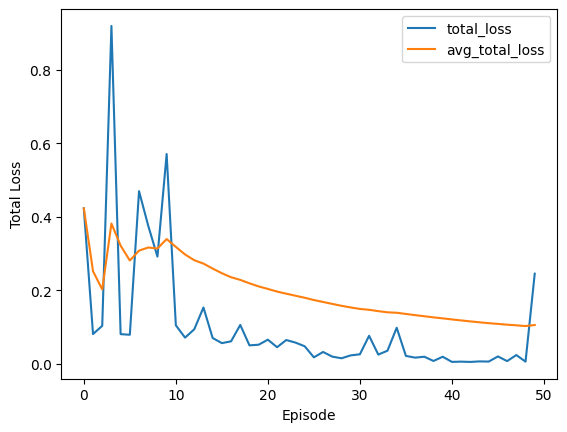

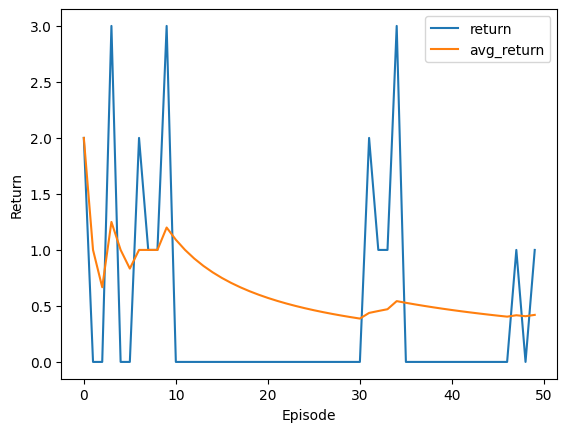

In [ ]:
# LAB: one experiment

# Definition of the experiment

# environment
env_name = ["pong","breakout","boxing"][1]
# model
model = ["dqn","dueldqn"][1]
# double or not Q-learning
double = ["yes","no"][1]
# learning rate of Q-learning algorithm (or SGD)
lr = 2.5e-4
# num of epochs = num of episodes
n_episodes = 50
# minibatch dimension/ number of used samples for a step of SGD/ number of samples extracted from buffer every time
batch_size = 32
# buffer dimension
buffer_size = 50000
# after every eval_cycle episodes we evaluate the learned model with a video...
eval_cycle = 1000000
# adding constant reward to each state-action couples, in order to favour less endouring games
time_penalty = 0 #-0.001
# command to use Prioritized replay buffer or not. If yes, the first value is parameter alpha, the second is beta
priority = "No" #[0.6, 0.4] #"No"
# use 'cpu' or 'gpu' to train NN
device = 'cuda' #'gpu' or 0

# hyperparameters

GAMMA = 0.99 # bellman function
EPS_START = 1 # epsilon largest value <=> largest exploration
EPS_END = 0.05  # epsilon lowest value <=> lowest exploration
EPS_DECAY = 65000 # 50000 #200000  # rate of decay of epsilon during policy improvements
WARMUP = 1000  # = number of episodes we do interacting with the environment with an agent that takes uniformly actions, before to start training
# this is done to pick tuples of experience to fill with the buffer at the start

experiment_def = {
    "env_name":env_name,
    "model":model,
    "double":double,
    "lr":lr,
    "n_episodes":n_episodes,
    "batch_size":batch_size,
    "buffer_size":buffer_size,
    "eval_cycle":eval_cycle,
    "GAMMA":GAMMA,
    "EPS_START":EPS_START,
    "EPS_END":EPS_END,
    "EPS_DECAY":EPS_DECAY,
    "WARMUP":WARMUP,
    "time_penalty":time_penalty,
    "priority":priority,
    "device": device
}

# do experiment

results = experiment(**experiment_def)

# plot total_loss-epoch and return-epoch
plt.figure(1)
plt.xlabel("Episode")
plt.ylabel("Total Loss")
plt.plot(range(len(results.get("lossList"))),results.get("lossList"),label="total_loss")
plt.plot(range(len(results.get("lossList"))),results.get("avglosslist"),label="avg_total_loss")
plt.legend()

plt.figure(2)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.plot(range(len(results.get("returnList"))),results.get("returnList"),label="return")
plt.plot(range(len(results.get("returnList"))),results.get("avgreturnlist"), label="avg_return")
plt.legend()

In [ ]:
# LAB: comparison experiment

# Compare the performance of the learned policy during the training of the 4 methods. Choose the game to use!

env_name = ["pong","breakout","boxing"][1]
lr = 2.5e-4
n_episodes = 4000
batch_size = 32
buffer_size = 50000
eval_cycle = 1000000 #####
time_penalty = 0 #-0.001
priority = "No" #[0.6, 0.4] #"No"
device = 'cuda' #'gpu' or 0

GAMMA = 0.99
EPS_START = 1
EPS_END = 0.05
EPS_DECAY = 55000 #50000
WARMUP = 1000
time_penalty = 0

results = []

for model in ["dqn","dueldqn"]:
    for double in ["no"]: #["yes","no"]:
      experiment_def = {
              "env_name":env_name,
              "model":model,
              "double":double,
              "lr":lr,
              "n_episodes":n_episodes,
              "batch_size":batch_size,
              "buffer_size":buffer_size,
              "eval_cycle":eval_cycle,
              "GAMMA":GAMMA,
              "EPS_START":EPS_START,
              "EPS_END":EPS_END,
              "EPS_DECAY":EPS_DECAY,
              "WARMUP":WARMUP,
              "time_penalty":time_penalty,
              "priority":priority,
              "device": device
              }
      results.append(experiment(**experiment_def))


plt.figure(1)
plt.title("Average Total Loss per episode")
i = 0
for model in ["dqn","dueldqn"]:
    for double in ["no"]:#["yes","no"]:
        res = results[i].copy()
        plt.plot(range(len(res.get("lossList"))),res.get("avglosslist"),label=res.get("methodname"))
        i += 1
plt.legend()
plt.xlabel("Episode")
plt.ylabel("Average Total Loss")
plt.show()

plt.figure(2)
plt.title("Average Return per episode")
i = 0
for model in ["dqn","dueldqn"]:
    for double in ["no"]:#["yes","no"]:
        res = results[i].copy()
        plt.plot(range(len(res.get("returnList"))),res.get("avgreturnlist"), label=res.get("methodname"))
        i += 1
plt.legend()
plt.xlabel("Episode")
plt.ylabel("Average Return")
plt.show()


Output streaming troncato alle ultime 5000 righe.
episode 1675: Loss 8.92, Return 1.0, Avgloss 12.37, Avgreturn 2.71, Epsilon 0.18, TotalStep 111363
episode 1676: Loss 9.32, Return 1.0, Avgloss 12.41, Avgreturn 2.71, Epsilon 0.18, TotalStep 111439
episode 1677: Loss 2.18, Return 0.0, Avgloss 12.39, Avgreturn 2.70, Epsilon 0.18, TotalStep 111462
episode 1678: Loss 21.11, Return 4.0, Avgloss 12.50, Avgreturn 2.72, Epsilon 0.17, TotalStep 111646
episode 1679: Loss 10.81, Return 2.0, Avgloss 12.54, Avgreturn 2.73, Epsilon 0.17, TotalStep 111728
episode 1680: Loss 9.99, Return 2.0, Avgloss 12.56, Avgreturn 2.74, Epsilon 0.17, TotalStep 111812
episode 1681: Loss 10.72, Return 2.0, Avgloss 12.58, Avgreturn 2.75, Epsilon 0.17, TotalStep 111914
episode 1682: Loss 12.29, Return 2.0, Avgloss 12.61, Avgreturn 2.75, Epsilon 0.17, TotalStep 112016
episode 1683: Loss 16.52, Return 3.0, Avgloss 12.55, Avgreturn 2.73, Epsilon 0.17, TotalStep 112131
episode 1684: Loss 21.63, Return 3.0, Avgloss 12.59, A

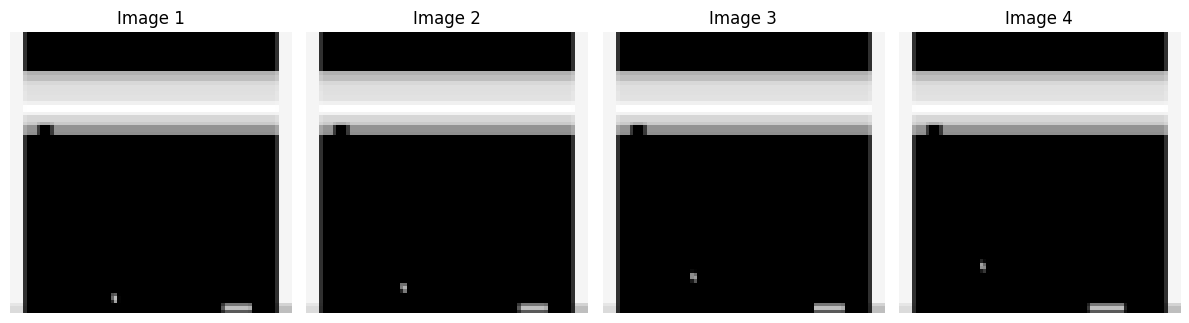

In [ ]:
# SALIENCY MAP

# Prepare the input

env = gym.make("BreakoutNoFrameskip-v4")
env = AtariWrapper(env)
n_action = env.action_space.n # pong:6; breakout:4; boxing:18

obs, info = env.reset() # (84,84)  # reset the environment and take initial state obs
obs = torch.from_numpy(obs).to('cpu') #(84,84)
# stack four frames together, hoping to learn temporal info
obs = torch.stack((obs,obs,obs,obs)).unsqueeze(0) #(1,4,84,84)  # state as 4 images!

# step loop
for step in range(100):  # do one (uniform) interaction with the environment until ...
        # take one step
        action = torch.tensor([[env.action_space.sample()]]).to('cpu')  # take randomly an action between the availables
        next_obs, reward, terminated, truncated, info = env.step(action.item())
        done = terminated or truncated

        # convert to tensor
        reward = torch.tensor([reward],device='cpu') # (1)
        done = torch.tensor([done],device='cpu') # (1)
        next_obs = torch.from_numpy(next_obs).to('cpu') # (84,84)
        next_obs = torch.stack((next_obs,obs[0][0],obs[0][1],obs[0][2])).unsqueeze(0) # (1,4,84,84)

        # move to next state
        obs = next_obs

sal_input = obs
sal_input = sal_input.squeeze(0)  # Ora le dimensioni sono (4, 84, 84)

# Plotta le 4 immagini
fig, axes = plt.subplots(1, 4, figsize=(12, 4))  # 1 riga, 4 colonne

for i in range(4):
    ax = axes[i]
    ax.imshow(sal_input[i].cpu().numpy(), cmap="gray")  # Converti in numpy e usa scala di grigi
    ax.axis("off")  # Rimuovi assi
    ax.set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

# Now, let's permit to compute the gradient of the network with respect to such input
sal_input = sal_input.unsqueeze(0)
sal_input = sal_input.requires_grad_()

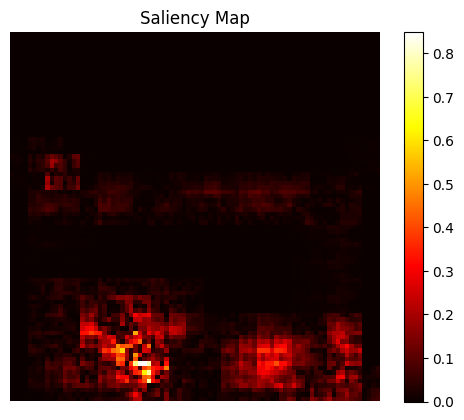

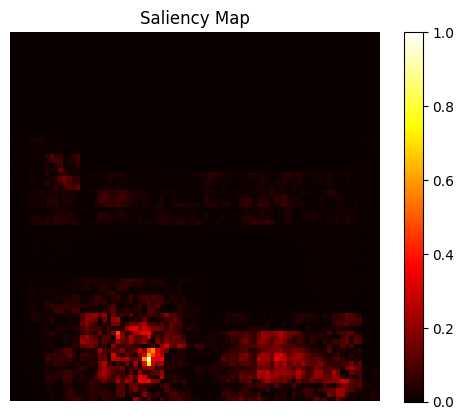

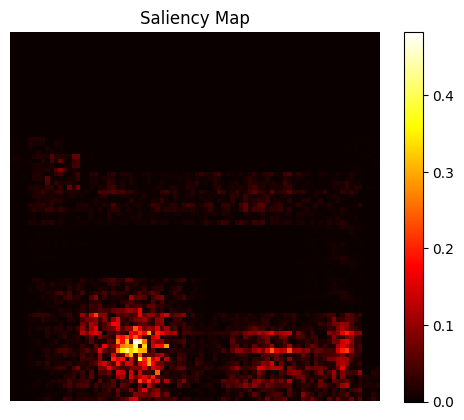

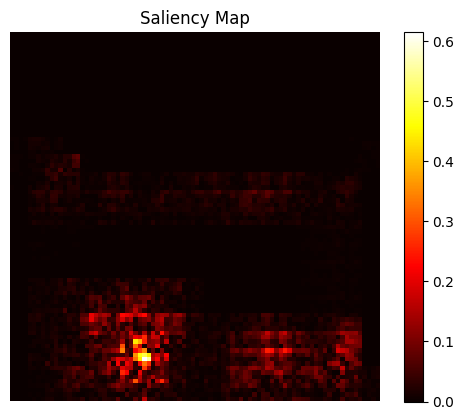

In [ ]:
# Saliency map for an output neuron

# move the network policy_net to the same device as the input (cpu)
policy_net.to('cpu')

# Propaga l'input nella rete
policy_net.eval()  # Modalità eval per la rete

#for param in policy_net.parameters():
#    param.requires_grad = True

output = policy_net(sal_input)

# Supponiamo che il neurone di interesse sia il neurone i-esimo nell'output
neuron_index = 0  # => prendiamo il primo neurone di output, ovvero quello corrispondente a Q(s,a) per a = prima azione
neuron_value = output[0, neuron_index]  # Estrai il valore del neurone di interesse

# Calcola il gradiente del neurone rispetto all'input
neuron_value.backward()  # Backpropagation

# Saliency map: |grad| su x
saliency = sal_input.grad.data.abs().squeeze()  # Prendi il gradiente assoluto e rimuovi dimensioni inutili

# Normalizza la saliency map per visualizzarla
saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

# Plot saliency map evaluated on input 4x84x84
plt.imshow(saliency[0].cpu().numpy(), cmap="hot")
plt.axis("off")
plt.colorbar()
plt.title("Saliency Map")
plt.show()

plt.imshow(saliency[1].cpu().numpy(), cmap="hot")
plt.axis("off")
plt.colorbar()
plt.title("Saliency Map")
plt.show()

plt.imshow(saliency[2].cpu().numpy(), cmap="hot")
plt.axis("off")
plt.colorbar()
plt.title("Saliency Map")
plt.show()

plt.imshow(saliency[3].cpu().numpy(), cmap="hot")
plt.axis("off")
plt.colorbar()
plt.title("Saliency Map")
plt.show()

torch.Size([1, 4, 84, 84])
torch.Size([1, 4, 84, 84])
(4, 84, 84)


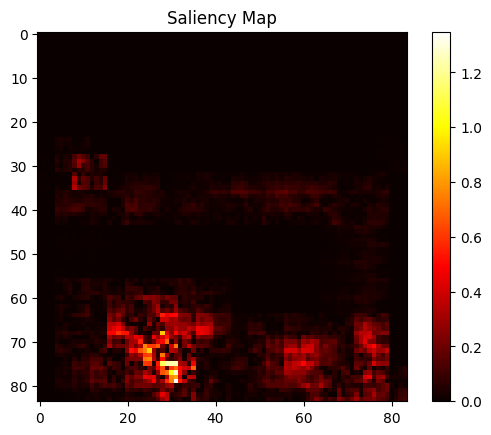

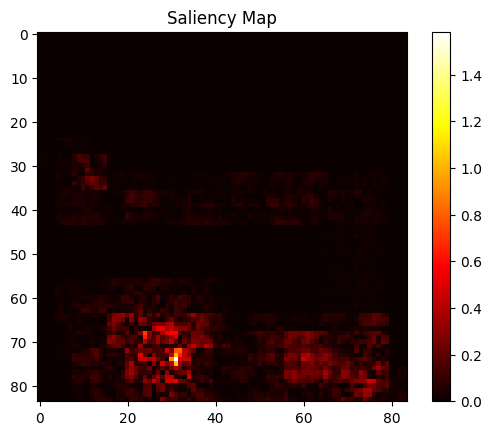

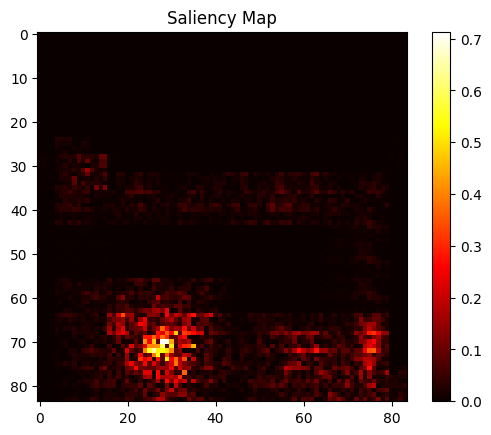

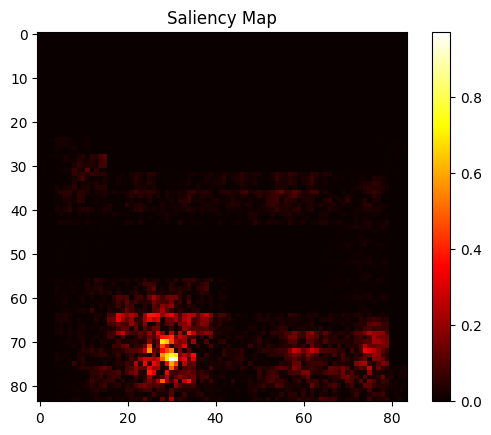

In [ ]:
# Saliency map for neuron of the value function V(s)

# Funzione per catturare le attivazioni
def save_activation(name):
    def hook(model, input, output):  # policy_net = trained NN
        activations[name] = output
    return hook

# Un dizionario per memorizzare le attivazioni
activations = {}

# Seleziona il layer in cui ti interessa calcolare la saliency (ad esempio, 'conv1')
sal_layer_val = policy_net.fc2_val

# Aggiungi un hook per catturare l'attivazione del layer
hook = sal_layer_val.register_forward_hook(save_activation('fc2_val'))

# Metti il modello in modalità di valutazione
policy_net.eval()

# Assicurati che l'input sia un tensore PyTorch con il giusto tipo di dati (float) e richieda gradienti
sal_input = sal_input.requires_grad_()  # Attiviamo il calcolo dei gradienti

# Passiamo il tensore nel modello
output = policy_net(sal_input)

# Ora recuperiamo l'attivazione del neurone che ci interessa
# Supponiamo che vogliamo il primo neurone del primo canale dell'attivazione
neuron_activation_val = activations['fc2_val'][0, 0]  # [N, C, H, W] -> [0, 0, :, :]

# Calcoliamo il gradiente dell'attivazione del neurone rispetto all'input
neuron_activation_val.backward(torch.ones_like(neuron_activation_val))  # Backprop per il neurone specifico

# Estraiamo il gradiente rispetto all'input
gradient = sal_input.grad.data  # Gradienti rispetto al tensore di input
print(gradient.shape)

# Calcoliamo la saliency map come il massimo dei gradienti assoluti lungo i canali
#saliency, _ = torch.max(gradient.abs(), dim=1)
saliency = gradient.abs()
print(saliency.shape)

# Convertiamo la saliency map in un formato adatto per la visualizzazione
saliency = saliency.squeeze().cpu().numpy()  # Rimuoviamo la dimensione extra e spostiamo su CPU per matplotlib
print(saliency.shape)

# Plot saliency map evaluated on input 4x84x84
plt.imshow(saliency[0], cmap='hot')
plt.colorbar()
plt.title('Saliency Map')
plt.show()

plt.imshow(saliency[1], cmap='hot')
plt.colorbar()
plt.title('Saliency Map')
plt.show()

plt.imshow(saliency[2], cmap='hot')
plt.colorbar()
plt.title('Saliency Map')
plt.show()

plt.imshow(saliency[3], cmap='hot')
plt.colorbar()
plt.title('Saliency Map')
plt.show()

# Non dimenticare di rimuovere l'hook
hook.remove()

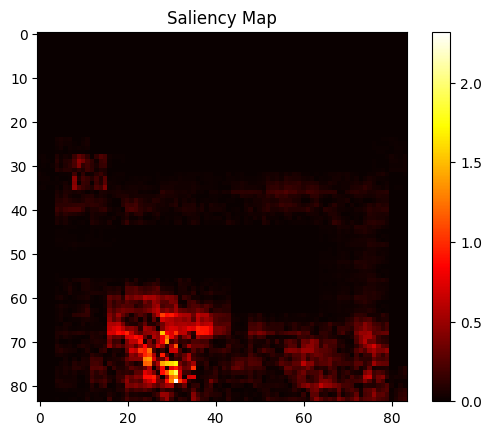

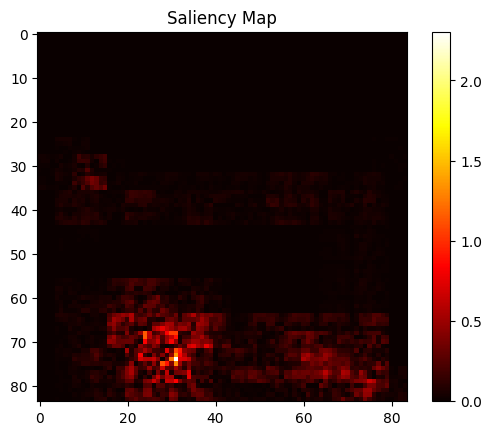

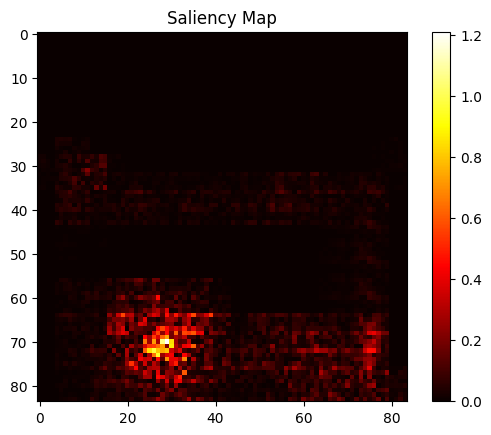

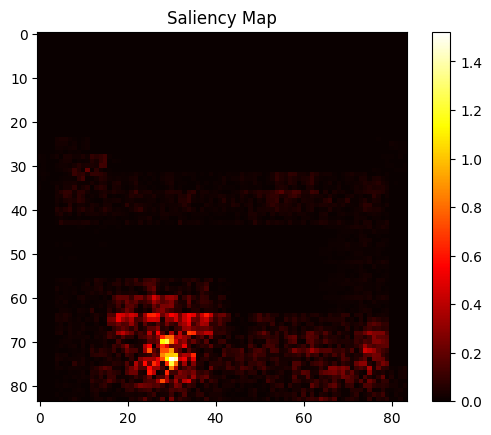

In [ ]:
# Saliency map for neuron of the advantage function A(s,a), for a certain action a

sal_layer_adv = policy_net.fc2_adv
hook = sal_layer_adv.register_forward_hook(save_activation('fc2_adv'))
policy_net.eval()
sal_input = sal_input.requires_grad_()  # Attiviamo il calcolo dei gradienti
output = policy_net(sal_input)
neuron_activation_adv = activations['fc2_adv'][0, 3]  # select action a = thrid one
neuron_activation_adv.backward(torch.ones_like(neuron_activation_adv))  # Backprop per il neurone specifico
gradient = sal_input.grad.data  # Gradienti rispetto al tensore di input
saliency = gradient.abs()
saliency = saliency.squeeze().cpu().numpy()  # Rimuoviamo la dimensione extra e spostiamo su CPU per matplotlib

# Plot saliency map evaluated on input 4x84x84
plt.imshow(saliency[0], cmap='hot')
plt.colorbar()
plt.title('Saliency Map')
plt.show()

plt.imshow(saliency[1], cmap='hot')
plt.colorbar()
plt.title('Saliency Map')
plt.show()

plt.imshow(saliency[2], cmap='hot')
plt.colorbar()
plt.title('Saliency Map')
plt.show()

plt.imshow(saliency[3], cmap='hot')
plt.colorbar()
plt.title('Saliency Map')
plt.show()

hook.remove()